## CHEME 5660: Estimating Geometric Brownian Motion Model Parameters from Data

### Introduction
Fill me in

### Lab setup
The code block below installs (and loads) any [Julia](https://julialang.org) packages that we need to complete the calculations. 

In [1]:
import Pkg; Pkg.activate("."); Pkg.resolve(); Pkg.instantiate();

  Activating project at `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/labs/lab-3-Calibration-GBM-Data`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/labs/lab-3-Calibration-GBM-Data/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/labs/lab-3-Calibration-GBM-Data/Manifest.toml`


In [2]:
using DataFrames
using CSV
using Distributions
using Statistics
using LinearAlgebra
using Plots
using Colors

### Load the lab 3 code library
The call to the `include` function loads the `CHEME-5660-Lab-2-Library.jl` library into the notebook; the library contains types and functions we use during the lab:

* The `E(X::Array{Float64,1},p::Array{Float64,1}) -> Float64` and `Var(X::Array{Float64,1}, p::Array{Float64,1}) -> Float64` functions compute the expectation and variance of the binomial price estimates given an array `X::Array{Float64,1}` of price values and associated probabilities `p::Array{Float64,1}`.
* The `build_probability_dictionary(model::CRRLatticeModel, levels::Int64) -> Dict{Int64, Array{Float64,1}}` function constructs a dictionary of probabilities for each level of the tree; keys are tree levels.
* The `build_nodes_dictionary(levels::Int64) -> Dict{Int64,Array{Int64,1}}` function constructs a dictionary of node indexs for each level of the tree; keys are the tree levels.

In [3]:
# load the code library -
include("CHEME-5660-Lab-3-Library.jl");

#### a) Load experimental data for QQQ
Load the historical OHLC data set for [Invesco QQQ Trust with ticker symbol QQQ](https://finance.yahoo.com/quote/QQQ/) into a [DataFrame](https://dataframes.juliadata.org/stable/). The OHLC data is stored in a comma seperated value (CSV) file format; use the [CSV](https://csv.juliadata.org/stable/) package to read the data and load into a [DataFrame](https://dataframes.juliadata.org/stable/).

In [4]:
df = CSV.read("./data/QQQ-OHLC-day-2017-08-25-to-2022-09-23.csv", DataFrame);

#### b) Estimate GBM model parameters for QQQ

In [5]:
N = nrow(df); # this is the number of rows in the total data set -

##### What percentage of the data do we want to use for training?

In [6]:
α = 0.75;

In [7]:
# split the data into to two chunks, training and validation
all_range = range(1,stop=N,step=1) |> collect
T_all = all_range*(1.0/365.0) .- (1.0/365.0)

training_range = range(1,stop=Int64(round(α*N)), step=1);
prediction_range = range(Int64(round(α*N))+1,stop=N, step=1);
df_training = df[training_range,:];
df_prediction = df[prediction_range,:];

#### c) Build a model

In [8]:
training_model = GeometricBrownianMotionModel()
training_model.μ = 0.0
training_model.σ = 0.0
training_model.T₁ = 0.0
training_model.T₂ = T_all[Int64(round(α*N))]
training_model.h = (1.0/365.0)
training_model.Xₒ = df_training[1,:close]

141.97

#### d) Estimate the $\mu$ parameter

In [9]:
# Setup the normal equations -
XD = [ones(Int64(round(α*N))) T_all[training_range]];
P̂ = log.(df_training[!,:close]);

# Solve the normal equations -
θ = inv(transpose(XD)*XD)*transpose(XD)*P̂;

# get estimated μ -
μ̂ = θ[2];

# update the training model -
training_model.μ = 1.05*μ̂;

In [10]:
actual_expectation = E(df_training, :close);

In [11]:
expected_value_training_array = E(training_model);

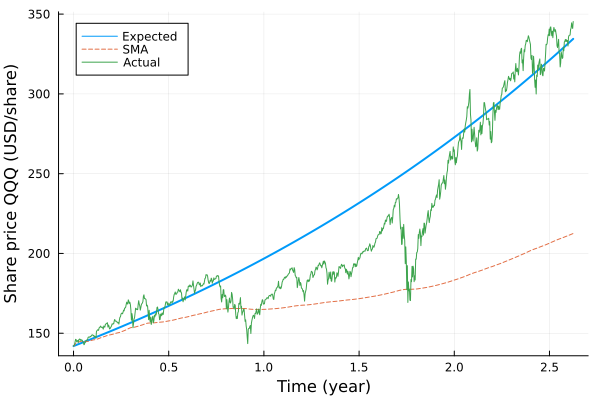

In [12]:
plot(expected_value_training_array[:,1], expected_value_training_array[:,2], label="Expected", legend=:topleft, lw=2)
plot!(actual_expectation[:,1],actual_expectation[:,2], label="SMA", ls=:dash,lw=2)
plot!(T_all[training_range], df_training[:,:close], label="Actual")

# label the plots -
xlabel!("Time (year)", fontsize=18)
ylabel!("Share price QQQ (USD/share)", fontsize=18)

#### e) Estimate the $\sigma$ parameter

In [13]:
# update the model with a guess σ -
training_model.σ = 0.108

# compute the variance of the model -
variance_training_model = Var(training_model);

# compute the variance of the data -
variance_training_data = Var(df_training,Symbol("close"));

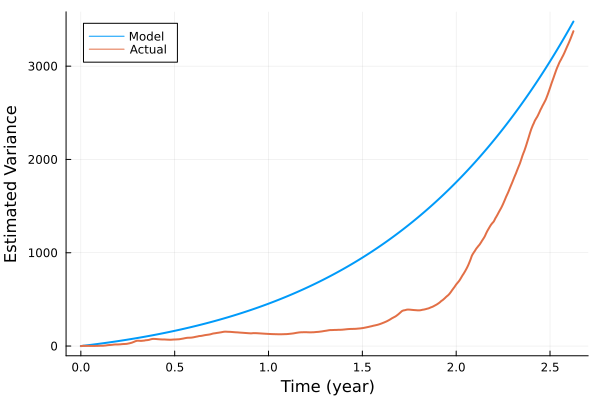

In [14]:
plot(variance_training_model[:,1], variance_training_model[:,2], label="Model", legend=:topleft, lw=2)
plot!(variance_training_data[:,1], variance_training_data[:,2],label="Actual", lw=2)

# label the plots -
xlabel!("Time (year)", fontsize=18)
ylabel!("Estimated Variance", fontsize=18)

#### e) In sample training model simulation

In [15]:
in_sample_simulation = solve(training_model);

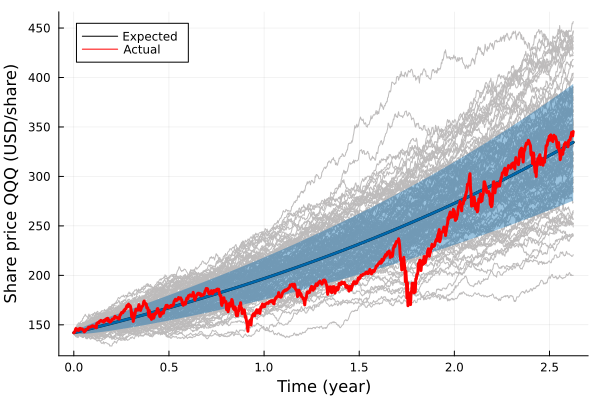

In [16]:
# setup bounds -
L = expected_value_training_array[:,2] .- sqrt.(variance_training_model[:,2])
U = expected_value_training_array[:,2] .+ sqrt.(variance_training_model[:,2])

# plot the in sample simulation -
plot(in_sample_simulation[:,1], in_sample_simulation[:,2:end], label="", c=colorant"#BDBBBB", legend=:topleft);
plot!(expected_value_training_array[:,1], expected_value_training_array[:,2],c=:black,lw=3,label="Expected")
plot!(expected_value_training_array[:,1], expected_value_training_array[:,2],c=colorant"#0068AC", fillrange=U, fillalpha = 0.4, lw=2, label="")
plot!(expected_value_training_array[:,1], expected_value_training_array[:,2],c=colorant"#0068AC", fillrange=L, fillalpha = 0.4, lw=2, label="")

# plot the data -
plot!(T_all[training_range],df_training[!,:close], lw=3, c=:red, label="Actual")

# label the plots -
xlabel!("Time (year)", fontsize=18)
ylabel!("Share price QQQ (USD/share)", fontsize=18)

#### f) Out of sample model prediction

In [17]:
prediction_model = GeometricBrownianMotionModel()
prediction_model.μ = training_model.μ
prediction_model.σ = training_model.σ
prediction_model.T₁ = T_all[Int64(round(α*N))]
prediction_model.T₂ = T_all[end]
prediction_model.h = (1.0/365.0)
prediction_model.Xₒ = df_prediction[1,:close]

342.63

In [18]:
df_prediction[1,:close]

342.63

In [19]:
out_sample_simulation = solve(prediction_model);

In [20]:
# compute the variance of the model -
variance_prediction_model = Var(prediction_model);

In [21]:
# compute the expectation -
expected_value_prediction_array = E(prediction_model);

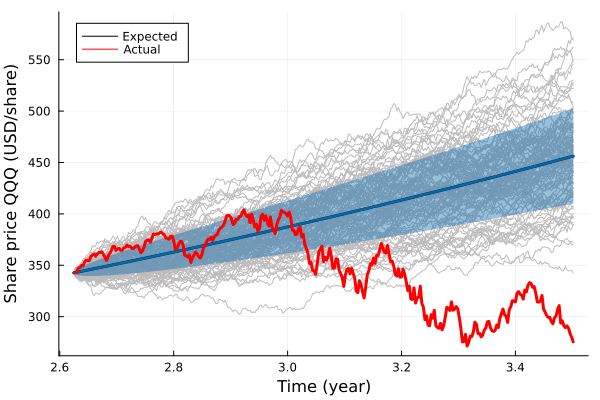

In [22]:
# setup bounds -
LP = expected_value_prediction_array[:,2] .- sqrt.(variance_prediction_model[:,2])
UP = expected_value_prediction_array[:,2] .+ sqrt.(variance_prediction_model[:,2])

# plot the in sample simulation -
plot(out_sample_simulation[:,1], out_sample_simulation[:,2:end], label="", c=colorant"#BDBBBB", legend=:topleft)
plot!(expected_value_prediction_array[:,1], expected_value_prediction_array[:,2],c=:black,lw=3, label="Expected")
plot!(expected_value_prediction_array[:,1], expected_value_prediction_array[:,2],c=colorant"#0068AC", fillrange=UP, fillalpha = 0.4, lw=2, label="")
plot!(expected_value_prediction_array[:,1], expected_value_prediction_array[:,2],c=colorant"#0068AC", fillrange=LP, fillalpha = 0.4, lw=2, label="")

# plot the data -
plot!(T_all[prediction_range],df_prediction[!,:close], lw=3, c=:red, label="Actual")

# label the plots -
xlabel!("Time (year)", fontsize=18)
ylabel!("Share price QQQ (USD/share)", fontsize=18)